In [199]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sn

In [200]:
f=pd.read_csv('Data_jan.csv',low_memory=False)
test=pd.read_csv('Data_feb.csv')

In [201]:
int(len(f)*0.8)

73787

In [202]:
df_col=pd.read_csv('features_coefficient6.csv')['feature'].to_list()

In [203]:
df_col=[]
check=[]
for x in f.columns:
    if f[x].isnull().sum() > 0:
        check.append([x,f[x].isnull().sum()])
    if f[x].isnull().sum() > 0 and f[x].isnull().sum()<60000:
        df_col.append(x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from current font.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 32593 (\N{CJK UNIFIED IDEOGRAPH-7F51}) missing from current font.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 28192 (\N{CJK UNIFIED IDEOGRAPH-6E20}) missing from current font.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 36947 (\N{CJK UNIFIED IDEOGRAPH-9053}) missing from current font.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20027 (\N{CJK UNIFIE

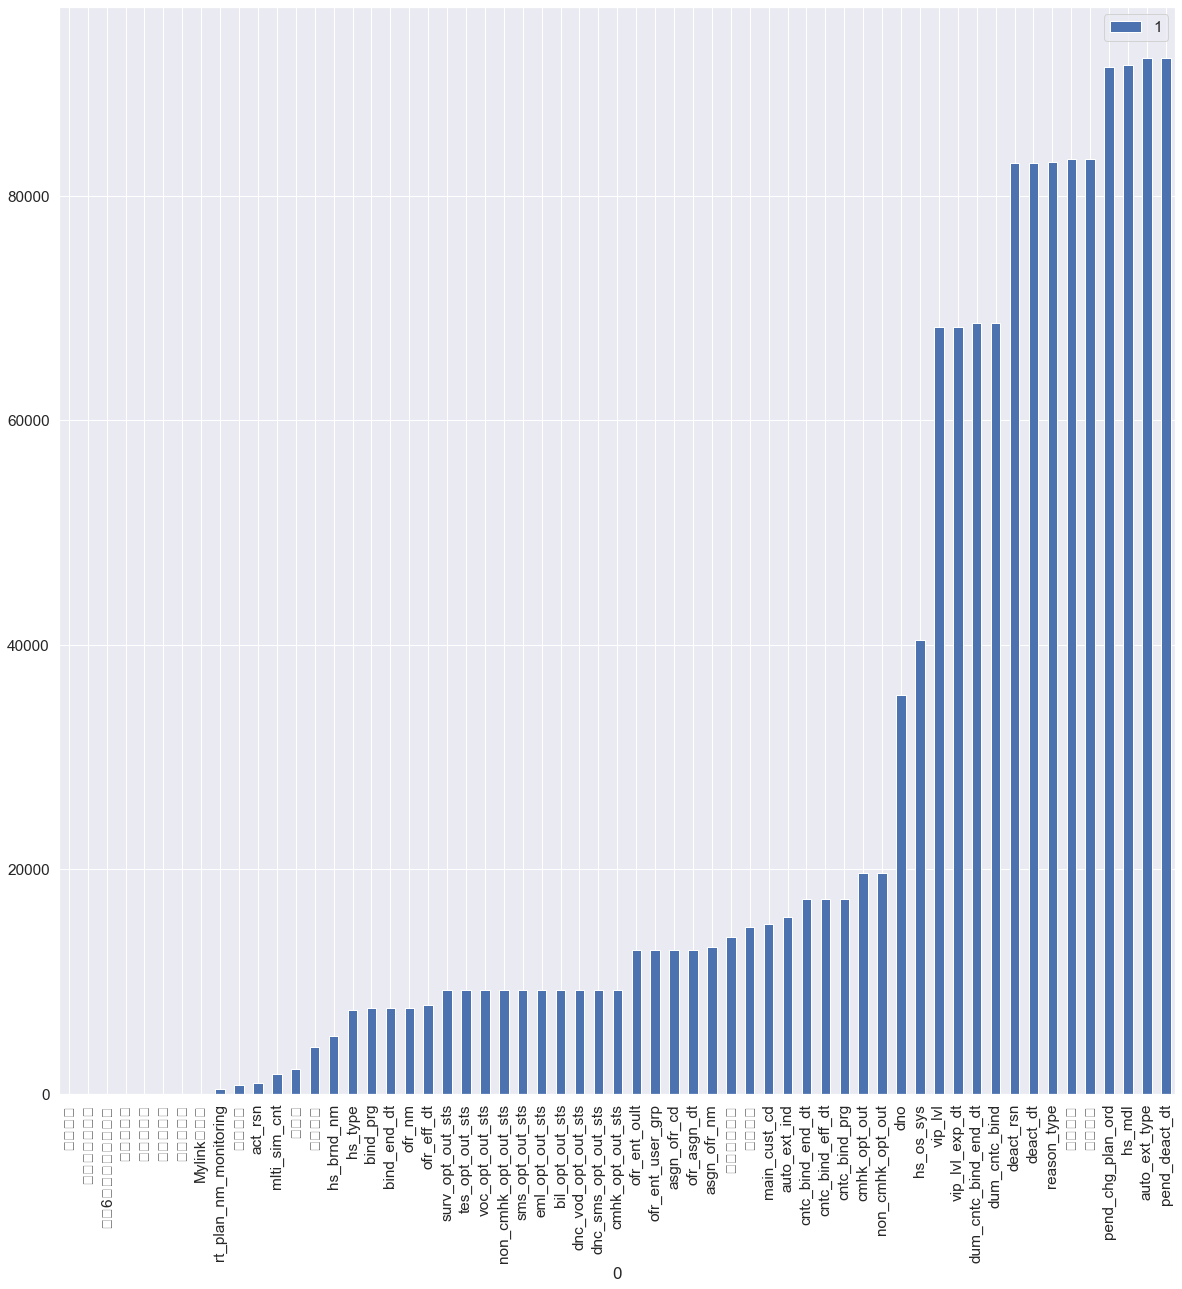

In [204]:
ccc=pd.DataFrame(check).set_index(0).sort_values(by=1)
plt.rcParams["figure.figsize"] = [20, 20]
# lines = date_vol_df.reset_index().plot.scatter(x='index',y=0)
lines = ccc.plot.bar()

----------------------------------Insight------------------------------------------

In [205]:
N_0_count=[]
tt=(test[test['是否离网']=='N']).drop(['离网日期'],axis=1)
for index, row in tt.iterrows():
    N_0_count.append(row[df_col].isnull().sum())

In [206]:
Y_0_count=[]
tt=test[test['是否离网']=='Y'].drop(['离网日期'],axis=1)
for index, row in tt.iterrows():
    Y_0_count.append(row[df_col].isnull().sum())

In [207]:
sat_Y=pd.DataFrame(Y_0_count,columns=['0_count']).join(pd.DataFrame([1]*len(Y_0_count),columns=['ref']))
barchart_Y=sat_Y.groupby(by=['0_count']).sum()
sat_N=pd.DataFrame(N_0_count,columns=['0_count']).join(pd.DataFrame([1]*len(N_0_count),columns=['ref']))
barchart_N=sat_N.groupby(by=['0_count']).sum()

(<AxesSubplot: xlabel='0_count'>, <AxesSubplot: xlabel='0_count'>)

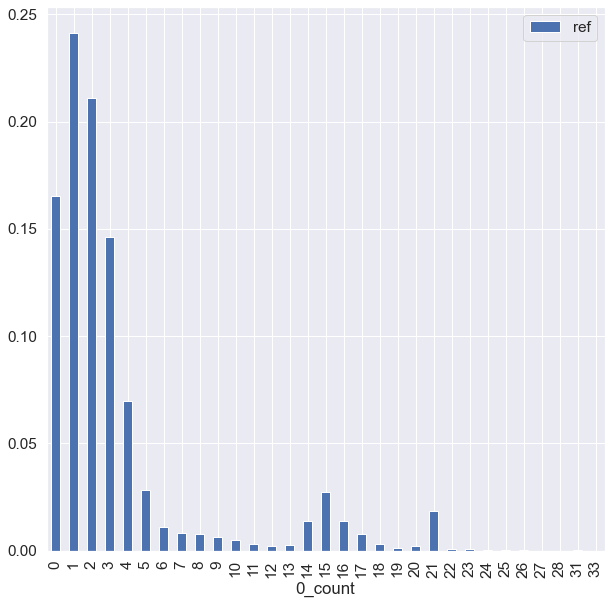

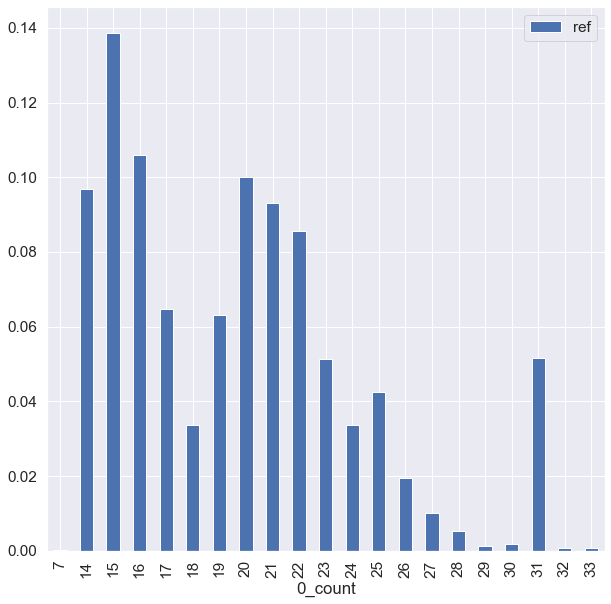

In [208]:
plt.rcParams["figure.figsize"] = [10, 10]
# lines = date_vol_df.reset_index().plot.scatter(x='index',y=0)
(barchart_N/len(N_0_count)).plot.bar(),(barchart_Y/len(Y_0_count)).plot.bar()

---------------------------------set Up------------------------------------------

In [209]:
_0_count_train=[]
tt=f.drop(['离网日期'],axis=1)
for index, row in tt.iterrows():
    _0_count_train.append(row[df_col].isnull().sum())

In [210]:
a=pd.get_dummies(f['是否离网']).astype(int)
b=a['Y'].replace(1,int(-1))+a['N']
y_train=b.to_frame('是否离网')

In [211]:
_0_count_test=[]
tt=test.drop(['离网日期'],axis=1)
for index, row in tt.iterrows():
    _0_count_test.append(row[df_col].isnull().sum())

In [212]:
a=pd.get_dummies(test['是否离网']).astype(int)
b=a['Y'].replace(1,int(-1))+a['N']
y_test=b.to_frame('是否离网')

----------------------------------模型 Set up------------------------------------------

In [221]:
clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(kernel='sigmoid',nu=0.01)

In [222]:
clf.fit(np.array(_0_count_train[:80000]).reshape(-1, 1), y_train.iloc[:80000]['是否离网'].to_numpy())

SVC(kernel='linear')

----------------------------------模型測試------------------------------------------

In [223]:
y_pred = clf.predict(np.array(_0_count_train[80000:]).reshape(-1, 1))
val=y_pred-y_train.iloc[80000:]['是否离网'].to_numpy()
(len(y_train.iloc[80000:]['是否离网'])-len(np.nonzero(val)[0]))/len(y_train.iloc[80000:]['是否离网'])*100

94.23737126042178

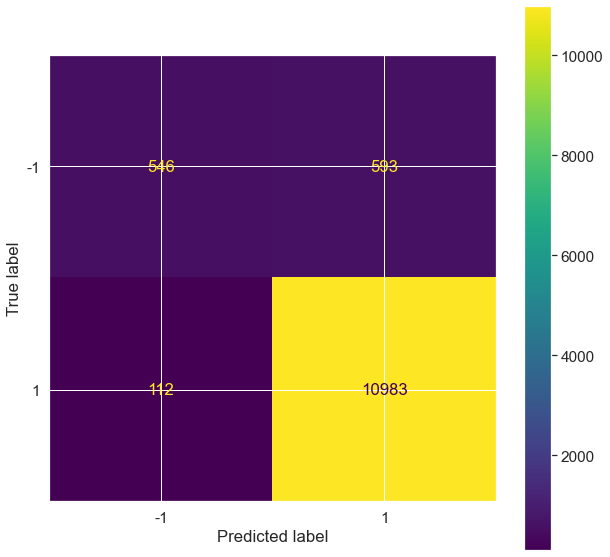

In [224]:
cm = confusion_matrix(y_train.iloc[80000:]['是否离网'].astype(int).to_numpy(), y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

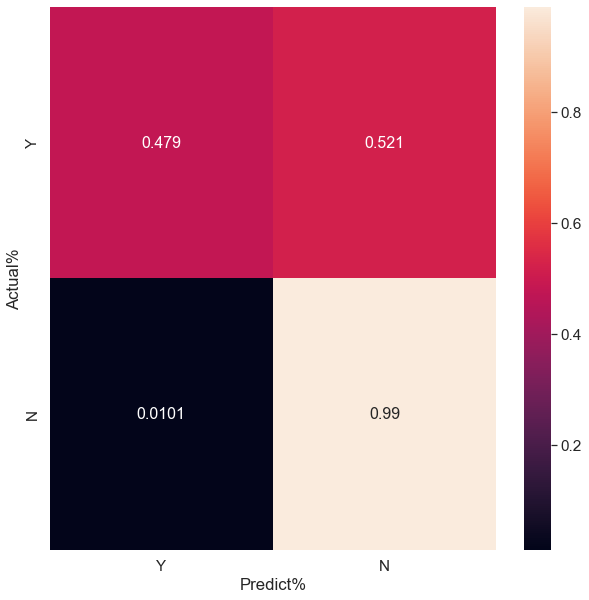

In [225]:
conf_prec=[cm[0][0]/np.sum(cm[0]),cm[0][1]/np.sum(cm[0]),cm[1][0]/np.sum(cm[1]),cm[1][1]/np.sum(cm[1])]
df_cm = pd.DataFrame(np.array(conf_prec).astype('float').reshape(2,2),index = ['Y','N'], columns =  ['Y','N'])
# plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.3g') # font size
plt.xlabel('Predict%')
plt.ylabel('Actual%')
sn.set(font_scale=1.4) # for label size

In [226]:
y_pred = clf.predict(np.array(_0_count_test).reshape(-1, 1))
val=y_pred-y_test['是否离网'].to_numpy()
(len(y_test)-len(np.nonzero(val)[0]))/len(y_test)*100

93.99790820859434

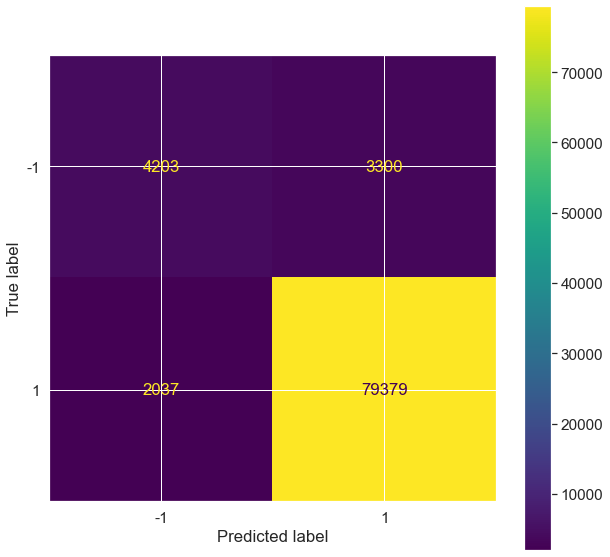

In [227]:
cm = confusion_matrix(y_test['是否离网'].astype(int).to_numpy(), y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

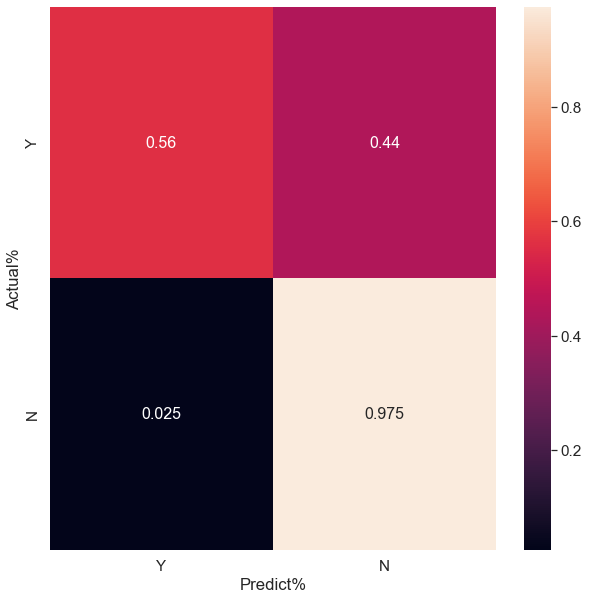

In [228]:
conf_prec=[cm[0][0]/np.sum(cm[0]),cm[0][1]/np.sum(cm[0]),cm[1][0]/np.sum(cm[1]),cm[1][1]/np.sum(cm[1])]
df_cm = pd.DataFrame(np.array(conf_prec).astype('float').reshape(2,2),index = ['Y','N'], columns =  ['Y','N'])
# plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.3g') # font size
plt.xlabel('Predict%')
plt.ylabel('Actual%')
sn.set(font_scale=1.4) # for label size